In [ ]:
# default_exp simulation
from nbdev import *
from utilities.ipynb_docgen import *

%reload_ext autoreload
%autoreload 2

# Simulation
> Generate simulated data

In [ ]:
# export
import os
import numpy as np
import pandas as pd
from scipy import stats

from wtlike.config import Config, PointSource

In [ ]:
# export
import numbers

class _Sampler():
    """ Sample an arbitrary function or histogram

    - func -- a function, a histogram, or a fixed value<br>
        If a function, must be positive definite.<br>
        Assume histogram bins are 0 to 1.
    - a,b  -- limits (default 0,1)
    - n    -- table size (ignored if a histogram or value)

    """

    def __init__(self, func, limits=(0,1), n=100):

        a,b = limits
        self.x = np.linspace(a,b,n+1) # bin edges
        dx = (b-a)/(n)/2
        self.deltafun=None

        if callable(func):
            # A function
            # evaluate at bin centers
            y = np.array([func(t-dx) for t in self.x])
            if np.any(y<0) or np.sum(y)==0:
                raise ValueError('Function is not positive definite')
        elif isinstance(func, numbers.Number):
            # a single value, or delta function
            self.deltafun = func
            if  func<0 or func>1:
                raise ValueError('Value not in range [0,1]')
            self.mean=func
            return
        else:
            n = len(func)
            self.x = np.linspace(a,b,n)
            y = func
        cy = np.cumsum(y)
        d = cy[-1]-cy[0]
        self.sy = (cy-cy[0])/d

        self.mean = np.sum( (self.x-dx) * y) / d

    def _evaluate(self, r):
        """evaluate inverse integral. expect 0<r<1 """
        return np.interp(r, self.sy, self.x)

    def __call__(self, size):
        """Generate `size` values
        """
        if self.deltafun: return np.full(size, self.deltafun)

        return self._evaluate(stats.uniform.rvs(size=size))

###   Gaussian and quadratic example functions


In [ ]:
# collapse_input
n = 20
sf = _Sampler(lambda x: np.exp(-(x**2)/2), limits=(-4, 4) )

data = sf(10000)
tests = np.array([np.abs(data.mean()), np.abs(data.std()-1) ])
assert np.all(tests<5e-2 ), f'Failed Tests: mean {data.mean()}, std {data.std()}'

func = lambda x: x**2
wfun = _Sampler(func)

test2 = wfun.mean,  np.mean(wfun(1000))
assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'

### Test generating weights from a source weight histogram

Test with a function peaked at both ends, generate equal signal and background

## Simulate times and weights

In [ ]:
# export
sec_per_day = 24*3600

def generate_times(start, stop, count):
    """ Generate a list of times, distributed randomly

    - start, stop: times
    - count : expected number to generate with rate=count/(stop-start)

    returns : list of times between start and stop. Note that the actual number is Poisson-distributed
    """
    # note: can speed this up by making groups of random calls

    tt =[]
    t = start
    scale = (stop-start)/count
    while True:
        t += np.random.exponential(scale =scale)
        if t>stop: break
        tt.append(t)
    return tt

In [ ]:
t = np.random.exponential(1, 100); 
#dt = np.diff(t); pd.Series.describe(dt)
dt = np.diff(t)
pd.Series(dt).describe()

count    9.90e+01
mean    -2.21e-03
std      1.49e+00
min     -3.80e+00
25%     -6.29e-01
50%     -4.79e-02
75%      8.30e-01
max      3.55e+00
dtype: float64

In [ ]:
#export
class WeightFunction(object):

    def __init__(self, s=1,b=1, wt_signif=0.1):
        self.s = s
        self.b = b
        self.lam = wt_signif

    def __call__(self, r):
        return (self.s * np.exp(-r/self.lam)/(self.lam*(1-np.exp(-1/self.lam))) + self.b)

    def sample(self, s,b, n):
        self.s = s
        self.b = b
        return _Sampler(self, n=1000)(n);

    def weights(self, s, b, n):
        h = self.sample(s,b,n)
        return 1-b/self(h)

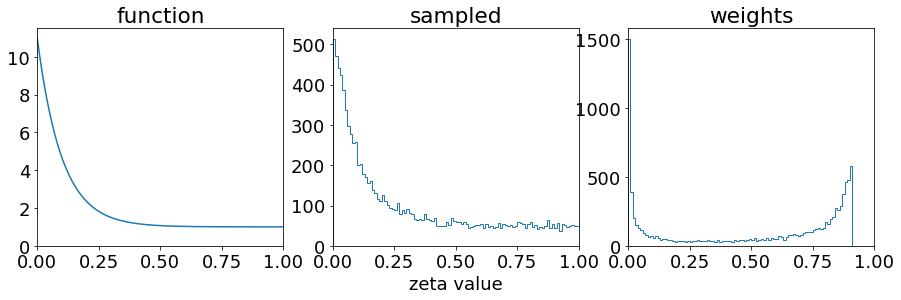

In [ ]:
#hide
# test weight function
s,b, lam = 1,1,0.1

r = np.linspace(0,1, 1000)  
wfun = WeightFunction(s=s,b=b,wt_signif=lam)
samp = wfun.sample(s,b, 10000); 
wts = wfun.weights(s,b, 10000);


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4), sharex=True)
ax1.plot(r, wfun(r), '-')
ax1.set(ylim=(0,None), xlim=(0,1), title='function');
ax2.hist(samp, 100);
ax2.set(title='sampled', xlabel='zeta value');
ax3.hist(wts, bins=np.linspace(0,1,101));
ax3.set(title='weights');

In [ ]:
#export
def make_exposure(fexp, start, stop, interval=300):
    """
    - fexp -- exposure in cm^2, a value or a function of time in day units
    - start, stop -- range of time in day units
    - interval [300] -- 5-min interval (fermi data is 30 s)

    Returns: a DataFrame with start, stop, exp
    """
    def check_scalar( f):
        if np.isscalar(f):
            fval = f
            return lambda t: fval
        return f
    fexp = check_scalar(fexp)

    nbins = int((stop-start)*sec_per_day / interval)
    edges = np.linspace(start, start+nbins*interval/sec_per_day, nbins+1)
    starts, stops = edges[:-1], edges[1:]
    exp = fexp(starts) * interval
    return pd.DataFrame.from_dict(dict(start=starts, stop=stops, exp=exp))

# exp  = make_exposure(500, 0, 1 )
# days  = np.sum(exp.stop-exp.start); secs = days*24*3600
# exptot=np.sum(exp.exp)
# exp_text = f' average {exptot/secs:.0f} cm^2 for {secs/1e6:.1f} Ms'
# print(exp_text)
# exp.head()

In [ ]:
# export
class Simulation(object):

    def __init__(self, name, src_flux, tstart, tstop, bkg_rate=1e-6,  efun=3000, wt_signif=0.1):
        """
        - src_flux : source flux, scalar or function of days, typically around 1e-7
        - tstart, tstop :(days)
        - bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
        - efun : scalar, function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

        - wt_signif : now the width of the PSF in (r/rmax)**2 coordinates

        """
        def check_scalar( f):
            if np.isscalar(f):
                fval = f
                return lambda t: fval
            return f
        self.name = name
        self.src_fun = check_scalar(src_flux)
        self.bkg_fun = check_scalar(bkg_rate)
        self.flux_fun = lambda t: src_fun(t)+bkg_fun(t)
        self.wt_signif=wt_signif

        self.exposure = make_exposure(efun, tstart, tstop)


    def run(self):
        times = []
        weights = []
        for start, stop, exp in self.exposure.itertuples(index=False,name=None):

            src = self.src_fun((start+stop)/2)
            bkg = self.bkg_fun((start+stop)/2)
            delta_t = (stop-start)*sec_per_day # tolal tim
            counts = (src+bkg) * exp #
            #print(f'From {start} to {stop}, exposure/s {exp/delta_t:.0f}, counts {counts:.0f}')
            new_times = generate_times(start, stop, counts)
            wfun = WeightFunction(wt_signif=self.wt_signif)
            new_wts = wfun.weights(s=src, b=bkg, n=len(new_times));

            assert len(new_times)==len(new_wts)
            times = np.append(times, new_times)
            weights = np.append(weights, new_wts)

        print(f'generated {len(times)} photons')
        self.photons=pd.DataFrame(dict(time=times, weight=weights.astype(np.float32)))

In [ ]:
#hide
def src_flare(t, tzero=15, width=0.25, amp=2):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))
sim = Simulation('test_sim', src_flux=src_flare, tstart=0, tstop=10, )
%time sim.run()

generated 5180 photons
CPU times: user 9.74 s, sys: 176 ms, total: 9.92 s
Wall time: 9.91 s


## Test varying exposure


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_weights.ipynb.
Converted 04_exposure.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sat May 22 07:22:52 PDT 2021
